### **Description**

This recipe shows how to calculate statistics for regional sub-domains using monthly-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---

In [1]:
# -- Import required packages -- #
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from nemo_cookbook import NEMODataTree

xr.set_options(display_style="text")

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 JRA-55 model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain/domain_cfg"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 667MB
Dimensions:        (t: 1, y: 331, x: 360, z: 75)
Dimensions without coordinates: t, y, x, z
Data variables: (12/54)
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2v            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e2u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    mask_csundef   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    nav_lat        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1, 2]
    DOMAIN_size_global:      [362, 332]
    DOMAIN_size_local:       [362, 332]
    DOMAIN_position_first:   [1, 1]
    DOMAIN_position_last:    [362, 332]
    DOMAIN_halo_size_start:  [0, 0]
    DOMAIN_halo_size_end:    [0, 0]
    DOMAIN_type:             BOX
    history:                 Mon Jun  5 12:41:32 2023: ncks -A mask.nc ORCA1_...
    NCO:                     4.4.7

**Next, we will import the sea surface temperature and sea surface salinity stored at T-points in a single dataset.**

**Typically, NEMO model outputs defined on T-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridT.nc` file(s).**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1m"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['tos_con', 'sos_abs']], compat="override")

ds_gridT

<xarray.Dataset> Size: 552MB
Dimensions:        (y: 331, x: 360, time_counter: 577)
Coordinates:
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time_counter, y, x) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sos_abs        (time_counter, y, x) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 3600 s)
    interval_operation:  3600 s
    interval_write:      1 month
    long_name:           sea_surface_conservative_temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and V-grid variables for the eORCA1 model.**

In [4]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain.rename({"z": "nav_lev"}), "gridT": ds_gridT}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 577)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 577, j: 331, i: 360, k: 75)
│       Coordinates:
│           time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           tos_con        (time_counter, j, i) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           sos_abs        (time_counter, j, i) float32 275MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridW
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphit         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) float64 600B 0.5 1.5 2.5 3.5 4.5 ... 71.5 72

### **Defining a Regional Sub-Domain using a Bounding Box**

**Now we have constructed our `NEMODataTree`, let's start by defining a regional sub-domain using a geographical bounding box.**


**By using the `clip_grid()` method, we permanently modify the size of the specfied grid stored in our NEMODataTree.**

**Alternatively, we can use `clip_domain()` to clip all of the grids associated with a given NEMO model domain to a given bounding box.**

In [ ]:
# Define bounding box (lon_min, lon_max, lat_min, lat_max)
bbox = (-80, 10, 20, 70)

# Clip eORCA1 model T-grid to bounding box:
nemo.clip_grid(grid='/gridT', bbox=bbox)

# Plotting time-mean sea surface temperature for the regional sub-domain:
nemo['/gridT']['tos_con'].mean(dim='time_counter').plot()

### **Defining a Regional Sub-Domain using a Polygon**

**Next, let's define a more complex regional sub-domain by constructing a mask using a polygon. Since we have already clipped the T-grid of our NEMODataTree parent domain, we will define a polygon comprised of longitude-latitude coordinates within this region.**

**We will use the Overturning in the Subpolar North Atlantic Program (OSNAP) observational array coordinates made available via the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/) to construct a polygon enclosing the North Atlantic subpolar gyre**.

In [5]:
# Open OSNAP gridded observations dataset: 
ds_osnap = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/OSNAP/OSNAP_Gridded_TSV_201408_202006_2023")

# Define a closed polygon which includes both the OSNAP West & East arrays:
lon_poly = np.concatenate([ds_osnap['LONGITUDE'].values, np.array([ds_osnap['LONGITUDE'][-1], ds_osnap['LONGITUDE'][0]])])
lat_poly = np.concatenate([ds_osnap['LATITUDE'].values, np.array([ds_osnap['LATITUDE'][0], ds_osnap['LATITUDE'][0]])])

**Now we have defined our polygon, we can use the `mask_with_polygon()` method to return the boolean mask classifying whether NEMO model grid points are inside (True) or outside (False) the polygon**

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_27281/3968140852.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')


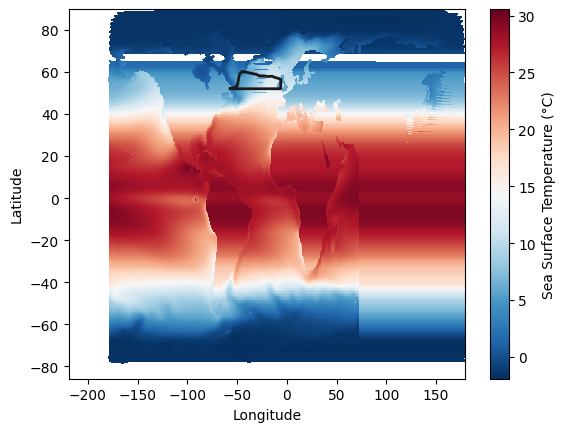

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_27281/3968140852.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter').where(mask_spg), cmap='RdBu_r')


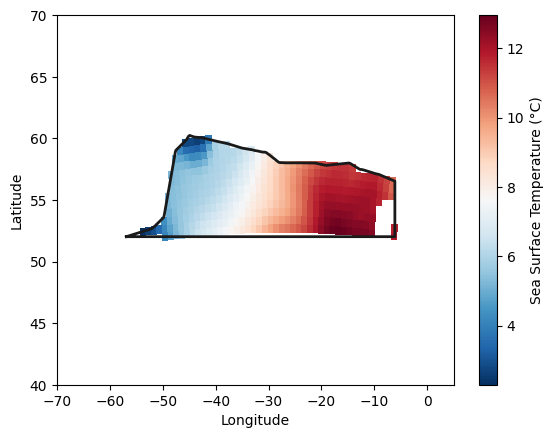

In [6]:
# Masking T-grid using polygon coordinates:
mask_spg = nemo.mask_with_polygon(grid='/gridT', lon_poly=lon_poly, lat_poly=lat_poly)

# Plotting SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting time-mean sea surface temperature for the SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter').where(mask_spg), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.xlim([-70, 5])
plt.ylabel('Latitude')
plt.ylim([40, 70])
plt.show()

## Developing section extraction:

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_27281/3709551922.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')


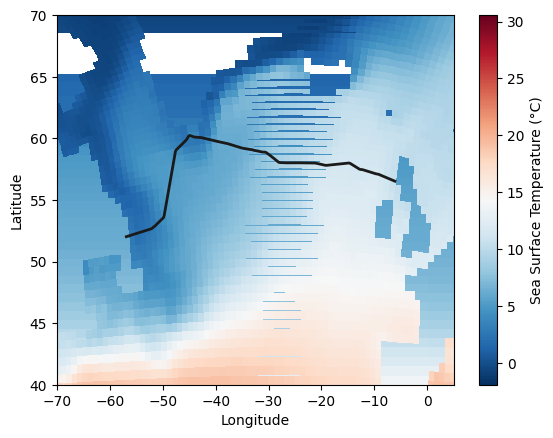

In [7]:
# Open OSNAP gridded observations dataset:
ds_osnap = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/OSNAP/OSNAP_Gridded_TSV_201408_202006_2023")

# Define a closed polygon which includes both the OSNAP West & East arrays:
lon_poly = np.concatenate([ds_osnap['LONGITUDE'].values, np.array([ds_osnap['LONGITUDE'][-1], ds_osnap['LONGITUDE'][0]])])
lat_poly = np.concatenate([ds_osnap['LATITUDE'].values, np.array([ds_osnap['LATITUDE'][0], ds_osnap['LATITUDE'][0]])])

# Plotting time-mean sea surface temperature for the SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(ds_osnap['LONGITUDE'].values, ds_osnap['LATITUDE'].values, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.xlim([-70, 5])
plt.ylabel('Latitude')
plt.ylim([40, 70])
plt.show()

In [8]:
# -- Testing with GSR -- #
import pandas as pd
# Open IHO World Seas polygons from GitHub as Pandas DataFrame:
IHO_World_Seas_filepath = "https://raw.githubusercontent.com/NOC-MSM/nemo_cookbook/main/docs/docs/assets/data/World_Seas_IHO_v3_polygons.parquet"

df_IHO_World_Seas = pd.read_parquet(IHO_World_Seas_filepath)
df_IHO_World_Seas

,ID,Name,MRGID,Longitudes,Latitudes
0,0,Rio de La Plata,4325,"[[-54.943023652717045, -54.978746687192626, -5...","[[-34.947906883078645, -34.97439280639835, -35..."
1,1,Bass Strait,4366,"[[149.90464234356938, 149.9049998519617, 149.9...","[[-37.54324781853184, -37.54805552943908, -37...."
2,2,Great Australian Bight,4276,"[[143.53250818354263, 143.54855731580784, 143....","[[-38.855345058560204, -38.89580867390668, -38..."
3,3,Tasman Sea,4365,"[[159.03333000000018, 159.03983414634163, 159....","[[-29.999999999999986, -30.043495934959335, -3..."
4,4,Mozambique Channel,4261,"[[43.38217926066437, 43.426910578414024, 43.47...","[[-11.370205640977488, -11.374667237992885, -1..."
...,...,...,...,...,...
96,96,Laccadive Sea,4269,"[[79.19056582495296, 79.20560240772511, 79.205...","[[9.28162992038466, 9.280296445224849, 9.28018..."
97,97,Skagerrak,2379,"[[10.66160702664314, 10.662945270907699, 10.66...","[[59.91287636715083, 59.910394549469004, 59.90..."
98,98,Norwegian Sea,2353,"[[16.72106314339885, 16.78890655530549, 16.856...","[[76.5645473926769, 76.50603497544391, 76.4475..."
99,99,Ligurian Sea,3363,"[[9.834412487214706, 9.835301503777828, 9.8349...","[[44.0485148685363, 44.04729517147973, 44.0472..."


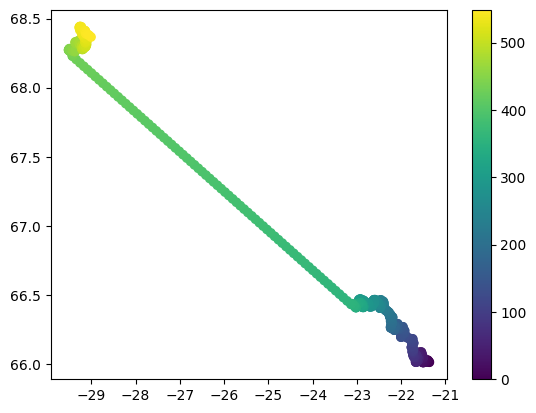

In [9]:
plt.scatter(df_IHO_World_Seas[df_IHO_World_Seas['Name'] == "Greenland Sea"]['Longitudes'].item()[0][9500:10050],
         df_IHO_World_Seas[df_IHO_World_Seas['Name'] == "Greenland Sea"]['Latitudes'].item()[0][9500:10050],
         c=np.arange(0, len(df_IHO_World_Seas[df_IHO_World_Seas['Name'] == "Greenland Sea"]['Longitudes'].item()[0][9500:10050])),
         cmap='viridis'
         )
plt.colorbar()

### **Extracting section from Arakawa C-grid**

In [10]:
# lons = ds_osnap['LONGITUDE'].values[:82]
# lats = ds_osnap['LATITUDE'].values[:82]
lons = ds_osnap['LONGITUDE'].values[85:]
lats = ds_osnap['LATITUDE'].values[85:]
# lons = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == "Greenland Sea"]['Longitudes'].item()[0][9500:10050]
# lats = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == "Greenland Sea"]['Latitudes'].item()[0][9500:10050]

In [11]:
from xarray.indexes import NDPointIndex
from nemo_cookbook.masks import get_mask_boundary
from xarray.indexes.nd_point_index import ScipyKDTreeAdapter

# -- Define section polygon -- #
# Ensure longitudes are monotonically increasing:
if lons[0] > lons[-1]:
    lons = lons[::-1]
    lats = lats[::-1]

lon_start = lons[0]
lat_start = lats[0]
lon_end = lons[-1]
lat_end = lats[-1]

dlat = 1.0

if lat_start < lat_end:
    lon_poly = np.concatenate([lons, np.array([lon_end, lon_start, lon_start])])
    lat_poly = np.concatenate([lats, np.array([lat_start - dlat, lat_start - dlat, lat_start])])
elif lat_start > lat_end:
    lon_poly = np.concatenate([lons, np.array([lon_end, lon_start, lon_start])])
    lat_poly = np.concatenate([lats, np.array([lat_end - dlat, lat_end - dlat, lat_start])])

# -- Create mask for section polygon -- #
mask_section = nemo.mask_with_polygon(grid='/gridT', lon_poly=lon_poly, lat_poly=lat_poly)

# -- Extract mask boundary -- #
# TODO: Add grid type kwarg.
i_bdy, j_bdy, flux_type, flux_dir = get_mask_boundary(mask_section)

# -- Construct boundary dataset -- #
# TODO: Turn into function to be re-used by extract_mask_boundary()
dom_str = ""
gridT = '/gridT'
gridU = '/gridU'
gridV = '/gridV'
k_name = "k"
time_name = "time_counter"

ds_bdy = xr.Dataset(
    data_vars={
    'i_bdy': (['bdy'], i_bdy[::-1]),
    'j_bdy': (['bdy'], j_bdy[::-1]),
    'flux_type': (['bdy'], flux_type[::-1]),
    'flux_dir': (['bdy'], flux_dir[::-1])
    },
    coords={
    time_name: nemo[gridT][time_name].values,
    k_name: nemo[gridT][k_name].values,
    'bdy': np.arange(len(i_bdy)),
    })

ubdy_mask = ds_bdy['flux_type'] == 'U'
vbdy_mask = ds_bdy['flux_type'] == 'V'

dim_sizes = [ds_bdy["bdy"].size]

# TODO: Check if depthu/v exists before assingning coords:
ds_bdy = ds_bdy.assign_coords({f"{dom_str}glamb": (['bdy'], np.zeros(ds_bdy["bdy"].size)),
                               f"{dom_str}gphib": (['bdy'], np.zeros(ds_bdy["bdy"].size)),
                            # f"{dom_str}depthb": ((k_name, 'bdy'), np.zeros(dim_sizes[1:])),
                            })

ds_bdy[f"{dom_str}glamb"][ubdy_mask] = nemo[gridU]['glamu'].sel(i=ds_bdy['i_bdy'][ubdy_mask], j=ds_bdy['j_bdy'][ubdy_mask])
ds_bdy[f"{dom_str}glamb"][vbdy_mask] = nemo[gridV]['glamv'].sel(i=ds_bdy['i_bdy'][vbdy_mask], j=ds_bdy['j_bdy'][vbdy_mask])

ds_bdy[f"{dom_str}gphib"][ubdy_mask] = nemo[gridU]['gphiu'].sel(i=ds_bdy['i_bdy'][ubdy_mask], j=ds_bdy['j_bdy'][ubdy_mask])
ds_bdy[f"{dom_str}gphib"][vbdy_mask] = nemo[gridV]['gphiv'].sel(i=ds_bdy['i_bdy'][vbdy_mask], j=ds_bdy['j_bdy'][vbdy_mask])

# ds_bdy[f"{dom_str}depthb"][:, ubdy_mask] = nemo[gridU]['depthu']
# ds_bdy[f"{dom_str}depthb"][:, vbdy_mask] = nemo[gridV]['depthv']

# -- Find nearest boundary points to section endpoints -- #
# TODO: Turn into function to return section indexes along boundary.
ds = (nemo['/gridV']
      .dataset
      .assign_coords({'gphiv': nemo['/gridV']['gphiv'].where(mask_section).fillna(0),
                      'glamv': nemo['/gridV']['glamv'].where(mask_section).fillna(0)
                      })
      .set_xindex(("gphiv", "glamv"), NDPointIndex, tree_adapter_cls=ScipyKDTreeAdapter))

i_start = ds.sel(glamv=lons[0], gphiv=lats[0], method="nearest")['i']
j_start = ds.sel(glamv=lons[0], gphiv=lats[0], method="nearest")['j']
i_end = ds.sel(glamv=lons[-1], gphiv=lats[-1], method="nearest")['i']
j_end = ds.sel(glamv=lons[-1], gphiv=lats[-1], method="nearest")['j']

# -- Define slice of boundary corresponding to section -- #
bdy_start = ds_bdy['bdy'].where((ds_bdy['i_bdy'] == i_start) & (ds_bdy['j_bdy'] == j_start), drop=True)
bdy_end = ds_bdy['bdy'].where((ds_bdy['i_bdy'] == i_end) & (ds_bdy['j_bdy'] == j_end), drop=True)

# If section includes full boundary start/end points:
if bdy_start.size > 1:
    if (bdy_start[0] == 0) & (bdy_start[-1] == ds_bdy['bdy'][-1]):
        bdy_start = bdy_start[0]
if bdy_end.size > 1:
    if (bdy_end[0] == 0) & (bdy_end[-1] == ds_bdy['bdy'][-1]):
        bdy_end = bdy_end[0]

# Define indexes of boundary points between section endpoints:
bdy_start, bdy_end = int(bdy_start.item()), int(bdy_end.item())
if bdy_end > bdy_start:
    bdy_ind = np.arange(bdy_start, bdy_end + 1).tolist()
elif bdy_end < bdy_start:
    bdy_ind = np.concatenate([np.arange(bdy_start, ds_bdy['bdy'][-1] + 1), np.arange(0, bdy_end + 1)]).tolist()
else:
    raise ValueError("section boundary start and end points are identical.")

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_27281/2025275461.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')


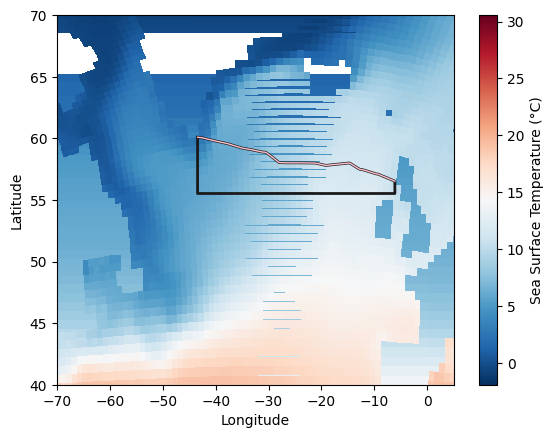

In [12]:
# Plotting time-mean sea surface temperature for the SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.plot(lons, lats, color='pink', lw=1)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.xlim([-70, 5])
plt.ylabel('Latitude')
plt.ylim([40, 70])
plt.show()

/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_27281/138046431.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter').where(mask_section), cmap='RdBu_r')


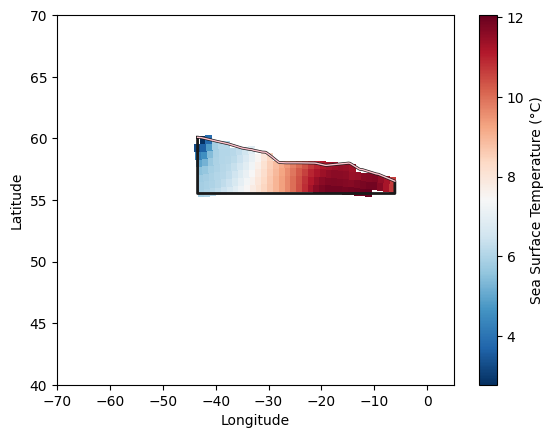

In [13]:
# Plotting time-mean sea surface temperature for the SPG polygon sub-domain:
plt.figure()
plt.pcolormesh(nemo['/gridT']['glamt'], nemo['/gridT']['gphit'], nemo['/gridT']['tos_con'].mean(dim='time_counter').where(mask_section), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.plot(lons, lats, color='pink', lw=1)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.xlim([-70, 5])
plt.ylabel('Latitude')
plt.ylim([40, 70])
plt.show()

(260.0, 280.0)

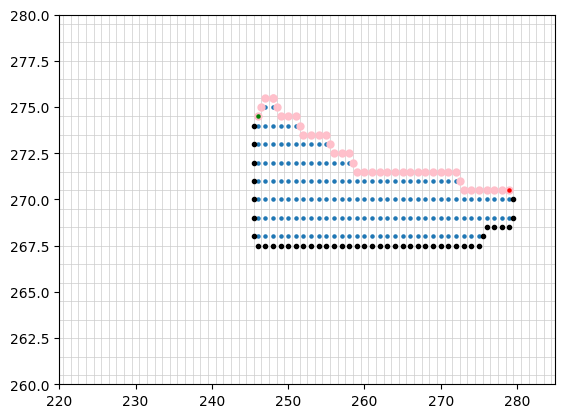

In [14]:
# -- Plotting section boundary on T-grid -- #
plt.figure()
for n in range(220, 300):
    plt.axvline(n + 0.5, color='0.8', lw=0.5)
for n in range(260, 300):
    plt.axhline(n + 0.5, color='0.8', lw=0.5)

plt.scatter(nemo['/gridT']['i'].expand_dims(j=nemo['/gridT']['j'], axis=0).where(mask_section),
            nemo['/gridT']['j'].expand_dims(i=nemo['/gridT']['i'], axis=1).where(mask_section),
            s=5, zorder=1
            )
plt.plot(ds_bdy['i_bdy'], ds_bdy['j_bdy'], 'k.', zorder=2)

plt.scatter(ds_bdy['i_bdy'][bdy_ind], ds_bdy['j_bdy'][bdy_ind], s=25, color='pink', zorder=3)
plt.scatter(i_start, j_start, color='green', s=5, label='Start', zorder=4)
plt.scatter(i_end, j_end, color='red', s=5, label='End', zorder=4)

# plt.xlim(255, 270)
# plt.ylim(280, 295)
plt.xlim(220, 285)
plt.ylim(260, 280)


In [ ]:
# TODO: Turn into re-usable function to extract section / boundary data variables.
import dask
ds_bdy = ds_bdy.isel(bdy=bdy_ind)

ubdy_mask = (ds_bdy['flux_type'] == 'U')
vbdy_mask = (ds_bdy['flux_type'] == 'V')

ds_bdy['velocity'] = xr.DataArray(data=dask.array.zeros(dim_sizes), dims=[time_name, k_name, 'bdy'])
ds_bdy['velocity'][:, :, ubdy_mask] = nemo[gridU]['e1u'].where(nemo[gridU]['umask']).sel(i=ds_bdy['i_bdy'][ubdy_mask], j=ds_bdy['j_bdy'][ubdy_mask]) * ds_bdy['flux_dir'][ubdy_mask]
ds_bdy['velocity'][:, :, vbdy_mask] = nemo[gridV]['e1v'].where(nemo[gridV]['vmask']).sel(i=ds_bdy['i_bdy'][vbdy_mask], j=ds_bdy['j_bdy'][vbdy_mask]) * ds_bdy['flux_dir'][vbdy_mask]

ds_bdy

In [ ]:
def extract_section_data(
        cls: NEMODataTree,
        lon_section: np.ndarray,
        lat_section: np.ndarray,
        uv_vars: list = ['uo', 'vo'],
        vars: list | None = None,
        dom: str = '.',
        ) -> xr.Dataset:
    """
    Extract hydrographic section from a NEMO model grid.

    Parameters
    ----------
    lon_section : np.ndarray
        Array of longitudes defining the section polygon.
    lat_section : np.ndarray
        Array of latitudes defining the section polygon.
    uv_vars : list, optional
        Names of velocity variables to extract along the boundary.
        Default is ['uo', 'vo'].
    vars : list, optional
        Names of scalar variables to extract along the boundary.
    dom : str, optional
        Domain string for the NEMODataTree (default is '.').

    Returns
    -------
    xr.Dataset
        Dataset containing hydrographic section extracted from NEMO model grid.
    """
    # -- Define grid paths -- #
    if dom == ".":
        gridT = "/gridT"
        gridU = "/gridU"
        gridV = "/gridV"
        dom_str = ""
    else:
        nodes = [n[0] for n in cls.subtree_with_keys if dom in n[0]]
        gridT = [n for n in nodes if "gridT" in n][0]
        gridU = gridT.replace("T", "U")
        gridV = gridT.replace("T", "V")
        dom_str = f"{dom}_"

    # -- Define section polygon -- #
    # Ensure longitudes are monotonically increasing:
    if lon_section[0] > lon_section[-1]:
        lon_section = lon_section[::-1]
        lat_section = lat_section[::-1]

    dlat = 1.0
    if lat_section[0] < lat_section[-1]:
        lon_poly = np.concatenate([lon_section, np.array([lon_section[-1], lon_section[0], lon_section[0]])])
        lat_poly = np.concatenate([lat_section, np.array([lat_section[0] - dlat, lat_section[0] - dlat, lat_section[0]])])
    elif lat_section[0] > lat_section[-1]:
        lon_poly = np.concatenate([lon_section, np.array([lon_section[-1], lon_section[0], lon_section[0]])])
        lat_poly = np.concatenate([lat_section, np.array([lat_section[-1] - dlat, lat_section[-1] - dlat, lat_section[-1]])])

    # -- Create mask for section polygon -- #
    mask = cls.mask_with_polygon(grid=gridT,
                                 lon_poly=lon_poly,
                                 lat_poly=lat_poly
                                 )

    # -- Extract mask boundary -- #
    i_bdy, j_bdy, flux_type, flux_dir = get_mask_boundary(mask)

    # -- Construct boundary dataset -- #
    k_name = f"k{dom}" if dom != '.' else "k"
    time_name = [dim for dim in cls[gridT].dims if 'time' in dim][0]

    ds = xr.Dataset(
        data_vars={
        'i_bdy': (['bdy'], i_bdy[::-1]),
        'j_bdy': (['bdy'], j_bdy[::-1]),
        'flux_type': (['bdy'], flux_type[::-1]),
        'flux_dir': (['bdy'], flux_dir[::-1])
        },
        coords={
        time_name: cls[gridT][time_name].values,
        k_name: cls[gridT][k_name].values,
        'bdy': np.arange(len(i_bdy)),
        })
    
    # -- Find nearest boundary points to section endpoints -- #
    # TODO: Turn into function to return section indexes along boundary.
    ds_endpoints = (cls[gridV]
                    .dataset
                    .assign_coords({'gphiv': cls[gridV]['gphiv'].where(mask_section).fillna(0),
                                    'glamv': cls[gridV]['glamv'].where(mask_section).fillna(0)
                                    })
                    .set_xindex(("gphiv", "glamv"), NDPointIndex, tree_adapter_cls=ScipyKDTreeAdapter)
                    )

    i_start = ds_endpoints.sel(glamv=lon_section[0], gphiv=lats[0], method="nearest")['i']
    j_start = ds_endpoints.sel(glamv=lon_section[0], gphiv=lats[0], method="nearest")['j']
    i_end = ds_endpoints.sel(glamv=lon_section[-1], gphiv=lats[-1], method="nearest")['i']
    j_end = ds_endpoints.sel(glamv=lon_section[-1], gphiv=lats[-1], method="nearest")['j']

    # -- Define section in terms of boundary indexes -- #
    sec_start = ds['bdy'].where((ds['i_bdy'] == i_start) & (ds['j_bdy'] == j_start), drop=True)
    sec_end = ds['bdy'].where((ds['i_bdy'] == i_end) & (ds['j_bdy'] == j_end), drop=True)

    # If section includes both boundary start & end points:
    if sec_start.size > 1:
        if (sec_start[0] == 0) & (sec_start[-1] == ds['bdy'][-1]):
            sec_start = sec_start[0]
    if sec_end.size > 1:
        if (sec_end[0] == 0) & (sec_end[-1] == ds['bdy'][-1]):
            sec_end = sec_end[0]

    sec_start, sec_end = int(sec_start.item()), int(sec_end.item())
    if sec_end > sec_start:
        sec_indexes = np.arange(sec_start, sec_end + 1).tolist()
    elif sec_end < sec_start:
        sec_indexes = np.concatenate([np.arange(sec_start, ds['bdy'][-1] + 1), np.arange(0, sec_end + 1)]).tolist()
    else:
        raise ValueError("section start and end point indexes are identical.")

    # -- Create hydrographic section dataset -- #
    ds = ds.isel(bdy=sec_indexes)
    ubdy_mask = (ds['flux_type'] == 'U')
    vbdy_mask = (ds['flux_type'] == 'V')
    dim_sizes = [cls[gridU][time_name].size, cls[gridU][k_name].size, ds["bdy"].size]

    # Add geographical coordinates & depths along-section:
    ds = ds.assign_coords({f"{dom_str}glamb": (['bdy'], np.zeros(ds["bdy"].size)),
                            f"{dom_str}gphib": (['bdy'], np.zeros(ds["bdy"].size)),
                            f"{dom_str}depthb": ((k_name, 'bdy'), np.zeros(dim_sizes[1:])),
                            })

    ds[f"{dom_str}glamb"][ubdy_mask] = cls[gridU]['glamu'].sel(i=ds['i_bdy'][ubdy_mask], j=ds['j_bdy'][ubdy_mask])
    ds[f"{dom_str}glamb"][vbdy_mask] = cls[gridV]['glamv'].sel(i=ds['i_bdy'][vbdy_mask], j=ds['j_bdy'][vbdy_mask])

    ds[f"{dom_str}gphib"][ubdy_mask] = cls[gridU]['gphiu'].sel(i=ds['i_bdy'][ubdy_mask], j=ds['j_bdy'][ubdy_mask])
    ds[f"{dom_str}gphib"][vbdy_mask] = cls[gridV]['gphiv'].sel(i=ds['i_bdy'][vbdy_mask], j=ds['j_bdy'][vbdy_mask])

    ds[f"{dom_str}depthb"][:, ubdy_mask] = cls[gridU]['depthu']
    ds[f"{dom_str}depthb"][:, vbdy_mask] = cls[gridV]['depthv']

    # Add velocities normal to boundary:
    if uv_vars[0] not in cls[gridU].data_vars:
        raise KeyError(f"variable '{uv_vars[0]}' not found in grid '{gridU}'.")
    if uv_vars[1] not in cls[gridV].data_vars:
        raise KeyError(f"variable '{uv_vars[1]}' not found in grid '{gridV}'.")

    ds['velocity'] = xr.DataArray(data=dask.array.zeros(dim_sizes), dims=[time_name, k_name, 'bdy'])
    ds['velocity'][:, :, ubdy_mask] = cls[gridU]['uo'].where(cls[gridU]['umask']).sel(i=ds['i_bdy'][ubdy_mask], j=ds['j_bdy'][ubdy_mask]) * ds['flux_dir'][ubdy_mask]
    ds['velocity'][:, :, vbdy_mask] = cls[gridV]['vo'].where(cls[gridV]['vmask']).sel(i=ds['i_bdy'][vbdy_mask], j=ds['j_bdy'][vbdy_mask]) * ds['flux_dir'][vbdy_mask]

    # Add scalar variables along-section:
    if vars is not None:
        for var in vars:
            if var in cls[gridT].data_vars:
                ds[var] = xr.DataArray(data=dask.array.zeros(dim_sizes), dims=[time_name, k_name, 'bdy'])
            else:
                raise KeyError(f"variable {var} not found in grid '{gridT}'.")
    
            # Linearly interpolate scalar variables onto NEMO model U/V grid points:
            ds[var][:, :, ubdy_mask] = 0.5 * (
                cls[gridT][var].where(cls[gridT]['tmask']).sel(i=ds['i_bdy'][ubdy_mask] - 0.5, j=ds['j_bdy'][ubdy_mask]) +
                cls[gridT][var].where(cls[gridT]['tmask']).sel(i=ds['i_bdy'][ubdy_mask] + 0.5, j=ds['j_bdy'][ubdy_mask])
                )
            ds[var][:, :, vbdy_mask] = 0.5 * (
                cls[gridT][var].where(cls[gridT]['tmask']).sel(i=ds['i_bdy'][vbdy_mask], j=ds['j_bdy'][vbdy_mask] - 0.5) +
                cls[gridT][var].where(cls[gridT]['tmask']).sel(i=ds['i_bdy'][vbdy_mask], j=ds['j_bdy'][vbdy_mask] + 0.5)
                )

    return ds

### **Calculating statistics for a Regional Sub-Domain**

**Finally, let's use our North Atlantic subpolar gyre polygon to calculate statistics for this regional sub-domain of the eORCA1 model.**

**Given a closed polygon, we can use the `masked_statistic()` method to calculate statistics of a specified variable in the masked sub-domain**

In [ ]:
# Calculating the area weighted-mean sea surface temperature in the SPG region:
sst_wmean = nemo.masked_statistic(grid="/gridT",
                                  var="tos_con",
                                  lon_poly=lon_poly,
                                  lat_poly=lat_poly,
                                  statistic="weighted_mean",
                                  dims=["i", "j"]
                                  )

sst_wmean.plot(lw=1, color='0.1', alpha=0.3)
sst_wmean.rolling(time_counter=12, center=True).mean().plot(lw=3, color='0.1')
plt.title('Area Weighted Mean SST for SPG Region', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)